In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


TEST_SIZE = 0.4

In [122]:
def load_data(filename):
    """
    Load the shopping CSV and apply simple preprocessing.

    - Reads `filename` into a DataFrame.
    - Encodes the `Month` column with LabelEncoder.
    - Converts `VisitorType` to a binary flag (Returning_Visitor -> 1 else 0).
    - Ensures `Weekend` is an integer (0/1).

    Returns
    -------
    evidence : pandas.DataFrame
        Feature matrix (all columns except the `Revenue` label).
    labels : pandas.Series
        Binary labels (Revenue converted to int).
    """
    df = pd.read_csv(filename)

    encoder = LabelEncoder()
    df['Month'] = encoder.fit_transform(df['Month'])
    df['VisitorType'] = (df['VisitorType'] == 'Returning_Visitor').astype(int)
    df['Weekend'] = df['Weekend'].astype(int)

    labels = df['Revenue'].astype(int)
    evidence = df.drop('Revenue', axis=1)

    return evidence, labels

In [123]:
def balance_classes(evidence, labels, alpha=0.25):
    """
    Balance the classes by oversampling the minority class.

    Notes on `alpha` (no behavior changes performed here):
    - Implementation oversamples the minority class to a target size computed as
      round((1 - alpha) * len(majority_class)).
    - alpha = 0.0 -> minority is oversampled up to the full majority size (fully balanced)
    - alpha > 0.0 -> minority is oversampled to a fraction of the majority size
      (e.g. alpha=0.25 -> minority oversampled to 75% of majority size)

    Parameters
    ----------
    evidence : pandas.DataFrame
        Feature matrix.
    labels : pandas.Series or array-like
        Binary labels (0/1).
    alpha : float, optional
        Controls the target oversample size (see notes above). Default 0.25.

    Returns
    -------
    balanced_evidence, balanced_labels
        DataFrame and Series with classes re-balanced according to `alpha`.
    """
    # Combine evidence and labels into a single DataFrame
    data = evidence.copy()
    data['Label'] = labels

    # Separate majority and minority classes
    majority_class = data[data['Label'] == 0]
    minority_class = data[data['Label'] == 1]

    # Undersample majority class (old approach - now using oversampling)
    # Oversample minority class to the target size computed from alpha
    minority_class_oversampled = minority_class.sample(n=round((1-alpha)*len(majority_class)), replace=True, random_state=42)

    # Combine majority class with oversampled minority class
    balanced_data = pd.concat([majority_class, minority_class_oversampled])

    # Shuffle the balanced dataset
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate evidence and labels
    balanced_labels = balanced_data['Label']
    balanced_evidence = balanced_data.drop('Label', axis=1)

    return balanced_evidence, balanced_labels

In [124]:
def preprocess_data():
    """
    Create and return a ColumnTransformer preprocessor.

    - Currently applies StandardScaler to a set of numeric duration / count features.
    - Keeps the transformer separate so it can be reused in a Pipeline.

    Returns
    -------
    preprocessor : sklearn.compose.ColumnTransformer
        Transformer that scales numeric columns.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', StandardScaler(), [ 'Administrative_Duration',
                                            'Informational_Duration',
                                            'ProductRelated',
                                            'ProductRelated_Duration',
                                            'PageValues'
                                                                                    ])

        ]
    )

    return preprocessor

In [125]:
def pipline():
    """
    Build and return two training pipelines:
      - KNN pipeline: preprocessing -> KNeighborsClassifier
      - LogisticRegression pipeline: preprocessing -> LogisticRegression

    Note: function name is `pipline` (typo) — keep it as-is to avoid breaking existing calls.
    Returns
    -------
    (knn_pipe, logreg_pipe) : tuple
        Two sklearn Pipeline objects ready for GridSearchCV or fitting.
    """
    preprocessor = preprocess_data()
    knn_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier()),
    ])

    # Add class_weight='balanced' to handle imbalanced data
    logreg_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor), 

            # it changes the decision boundary to account for class imbalance
            # penalize mistakes on the minority class more heavily
            ('logistic', LogisticRegression(class_weight='balanced', max_iter=1000))
        ]
    )
    return knn_pipe, logreg_pipe

In [126]:
def train_model(evidence, labels):
    """
    Given a list of evidence lists and a list of labels, run GridSearch over KNN
    hyperparameters for several alpha-balanced variants and over LogisticRegression.

    Returns the fitted GridSearchCV objects so callers can inspect `cv_results_`.
    """
    knn_pipe, logreg_pipe = pipline()
    
    # Define parameter grid including alpha values for balancing
    param_grid_knn = {
    'classifier__n_neighbors': [7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan'],
    }

    param_grid_logreg = {
        'logistic__C': [0.01, 0.1, 1, 10,20,100]
    }
    
    # Alpha values to try for balancing (0 = fully balanced, higher = more minority bias)
    alpha_values = [0.1, 0.15, 0.2, 0.25, 0.3]
    
    best_score = -1
    best_alpha = None
    best_knn_grid_search = None
    
    # Try each alpha value and keep the fitted GridSearchCV object for the best alpha
    for alpha in alpha_values:
        # Rebalance training data for this alpha
        balanced_evidence, balanced_labels = balance_classes(evidence, labels, alpha=alpha)

        # Grid search for KNN on the balanced data
        grid_search_knn = GridSearchCV(knn_pipe, param_grid_knn, cv=5, scoring='balanced_accuracy')
        grid_search_knn.fit(balanced_evidence, balanced_labels)
        
        if grid_search_knn.best_score_ > best_score:
            best_score = grid_search_knn.best_score_
            best_alpha = alpha
            best_knn_grid_search = grid_search_knn
    
    print(f"Best alpha for KNN: {best_alpha} (CV score: {best_score:.4f})")
    
    # Train logistic regression without balancing and keep the fitted GridSearchCV
    grid_search_logreg = GridSearchCV(logreg_pipe, param_grid_logreg, cv=5, scoring='balanced_accuracy')
    grid_search_logreg.fit(evidence, labels)
    
    # Return fitted GridSearchCV objects so caller can inspect cv_results_
    return best_knn_grid_search, grid_search_logreg

In [127]:
def evaluate(labels, predictions):
    """
    Compute sensitivity (true positive rate) and specificity (true negative rate).

    Parameters
    ----------
    labels : array-like
        Ground-truth binary labels (0/1).
    predictions : array-like
        Predicted binary labels (0/1).

    Returns
    -------
    (sensitivity, specificity) : tuple of floats
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
    """
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity, specificity

In [ ]:
def visualize_knn_results(df2: pd.DataFrame):

    df_manhattan = df2[df2["param_classifier__metric"] == "manhattan"]
    df_euclidean = df2[df2["param_classifier__metric"] == "euclidean"]

    # Plot mean CV score by K and weight type
    for w in df_manhattan["param_classifier__weights"].unique():
        subset = df_manhattan[df_manhattan["param_classifier__weights"] == w]
        plt.scatter(subset["param_classifier__n_neighbors"], subset["mean_test_score"], marker="o", label=w)

    for w in df_euclidean["param_classifier__weights"].unique():
        subset = df_euclidean[df_euclidean["param_classifier__weights"] == w]
        plt.scatter(subset["param_classifier__n_neighbors"], subset["mean_test_score"], marker="x", label=f"{w} (Euclidean)")

    plt.xlabel("Number of Neighbors (K)")
    plt.ylabel("Mean CV Score")
    plt.title("KNN Mean Test Score (Manhattan Distance and Euclidean Distance)")
    plt.legend(title="Weight Type and distance metric", loc="best")
    plt.grid(True)
    plt.show()


In [129]:
def main():
    """
    High-level runner:
    - Loads data
    - Splits train / test
    - Trains models (KNN with alpha tuning via GridSearchCV, LogisticRegression via GridSearchCV)
    - Evaluates on the test set and prints summary metrics

    Returns
    -------
    knn_gs, logreg_gs : fitted GridSearchCV objects
        The fitted GridSearchCV objects for KNN (best-alpha) and Logistic Regression.
    """

    # Load data from spreadsheet and split into train and test sets
    evidence, labels = load_data("shopping.csv")
    X_train, X_test, y_train, y_test = train_test_split(
        evidence, labels, test_size=TEST_SIZE, random_state=420, stratify=labels
    )

    # Train model and get fitted GridSearchCV objects
    knn_gs, logreg_gs = train_model(X_train, y_train)

    # Extract best estimators for prediction
    knn_model = knn_gs.best_estimator_ # type: ignore
    logreg_model = logreg_gs.best_estimator_

    predictions_knn = knn_model.predict(X_test) # type: ignore
    predictions_logreg = logreg_model.predict(X_test) 

    sensitivity, specificity = evaluate(y_test, predictions_knn)
    sensitivity_logreg, specificity_logreg = evaluate(y_test, predictions_logreg)

   


    # --- K-Nearest Neighbors (KNN) ---
    print("\n" + "="*50)
    print("K-Nearest Neighbors (KNN) Results")
    print("="*50)
    print(f"Correct Predictions     : {(y_test == predictions_knn).sum()}")
    print(f"Incorrect Predictions   : {(y_test != predictions_knn).sum()}")
    print(f"True Positive Rate (TPR): {100 * sensitivity:.2f}%")
    print(f"True Negative Rate (TNR): {100 * specificity:.2f}%")

    # --- Logistic Regression ---
    print("\n" + "="*50)
    print("Logistic Regression Results")
    print("="*50)
    print(f"Correct Predictions     : {(y_test == predictions_logreg).sum()}")
    print(f"Incorrect Predictions   : {(y_test != predictions_logreg).sum()}")
    print(f"True Positive Rate (TPR): {100 * sensitivity_logreg:.2f}%")
    print(f"True Negative Rate (TNR): {100 * specificity_logreg:.2f}%")

    # --- Classification Reports ---
    print("\n" + "="*50)
    print("Classification Report (KNN)")
    print("="*50)
    print(classification_report(y_test, predictions_knn))

    print("\n" + "="*50)
    print("Classification Report (Logistic Regression)")
    print("="*50)
    print(classification_report(y_test, predictions_logreg))

    # --- Best Model Parameters ---
    print("\n" + "="*50)
    print("Best Model Parameters from Grid Search")
    print("="*50)

    models = {
        "KNN": knn_gs.best_params_,  # type: ignore
        "Logistic Regression": logreg_gs.best_params_
    }

    for name, params in models.items():
        print(f"\n{name}:")
        for k, v in params.items():
            print(f"  {k:<30}: {v}")

    # --- Visualization ---
    print("\n" + "="*50)
    print("Visualizing KNN Grid Search Results...")
    print("="*50)
    visualize_knn_results(pd.DataFrame(knn_gs.cv_results_))  # type: ignore


Best alpha for KNN: 0.3 (CV score: 0.9312)

K-Nearest Neighbors (KNN) Results
Correct Predictions     : 4220
Incorrect Predictions   : 712
True Positive Rate (TPR): 72.61%
True Negative Rate (TNR): 87.93%

Logistic Regression Results
Correct Predictions     : 4316
Incorrect Predictions   : 616
True Positive Rate (TPR): 72.48%
True Negative Rate (TNR): 90.26%

Classification Report (KNN)
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      4169
           1       0.52      0.73      0.61       763

    accuracy                           0.86      4932
   macro avg       0.74      0.80      0.76      4932
weighted avg       0.88      0.86      0.86      4932


Classification Report (Logistic Regression)
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      4169
           1       0.58      0.72      0.64       763

    accuracy                           0.88      4932
   macro avg       0

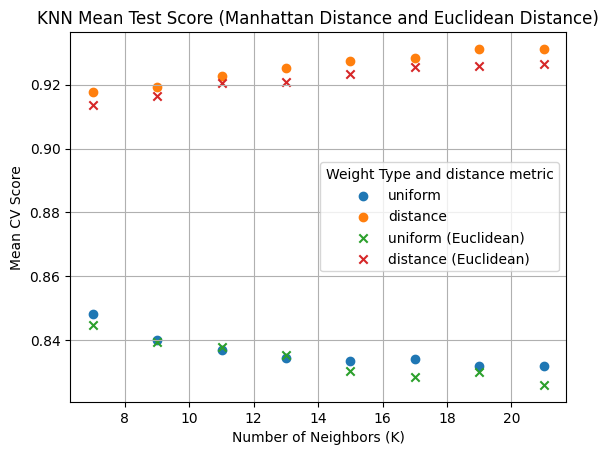

In [130]:
if __name__ == "__main__":
    
    main()
    
